<a href="https://colab.research.google.com/github/LEECHANGDAEE/colab/blob/main/cb_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
pip install catboost

In [119]:
pip install optuna-dashboard

In [120]:
# for "2. Data Loading"
import pandas as pd

# for "3-1. Feature Generation"
import numpy as np

# for "3-2. Feature Engineering"
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import RobustScaler, StandardScaler

# for "4. Modeling with Pycaret"
# from pycaret.regression import *

# for "5. Modeling with CatBoostRegressor"
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.integration import SkoptSampler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold

In [121]:
train = pd.read_csv('./train2.csv',encoding='cp949')
test = pd.read_csv('./test1.csv',encoding='cp949')
submission = pd.read_csv('./sample_submission1.csv',encoding='cp949')

In [122]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

#### (3) 자격유형

test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train = train.drop_duplicates()
test = test.drop_duplicates()

unique_cols = ['총세대수', '지역', '공가수', 
               '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
               '도보 10분거리 내 버스정류장 수',
               '단지내주차면수', '등록차량수']
train_agg = train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

X_train = pd.concat([train_agg,
                       reshape_cat_features(data=train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=train, cast_col='자격유형', value_col='counter')], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=test, cast_col='자격유형', value_col='counter')], axis=1)

In [123]:
X_train = X_train.drop(columns = ['임대건물구분_아파트'])
X_test = X_test.drop(columns = ['임대건물구분_아파트'])

In [124]:
display('Train Data')
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
display('Test Data')
display(X_test.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))
display('='*50)
# 지하철 역 수가 3인 데이터는 제거한다.

display('After Engineering')
X_train = X_train[X_train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] != 3]
display(X_train.groupby(['도보 10분거리 내 지하철역 수(환승노선 수 반영)'])['총세대수'].agg('count'))

'Train Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    367
1.0     38
2.0      5
3.0      1
Name: 총세대수, dtype: int64

'=================================================='

'Test Data'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    139
1.0      8
2.0      3
Name: 총세대수, dtype: int64

'=================================================='

'After Engineering'

도보 10분거리 내 지하철역 수(환승노선 수 반영)
0.0    367
1.0     38
2.0      5
Name: 총세대수, dtype: int64

In [125]:
%%time
encoding_features = ['지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)']
for f in encoding_features:
    mapping = X_train.groupby([f])['등록차량수'].agg(['mean','median','std'])
    mapping_values = []
    for l in X_train[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_train.index)
    X_train = pd.concat([X_train,bincount], axis= 1).drop(columns = [f])

    mapping_values = []
    for l in X_test[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_test.index)
    X_test = pd.concat([X_test,bincount], axis= 1).drop(columns = [f])

CPU times: user 131 ms, sys: 1 ms, total: 132 ms
Wall time: 131 ms


In [126]:
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '지역_mean', 
                     '지역_median',
                     '지역_std', 
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                   '도보 10분거리 내 지하철역 수(환승노선 수 반영)_std'
                    ]



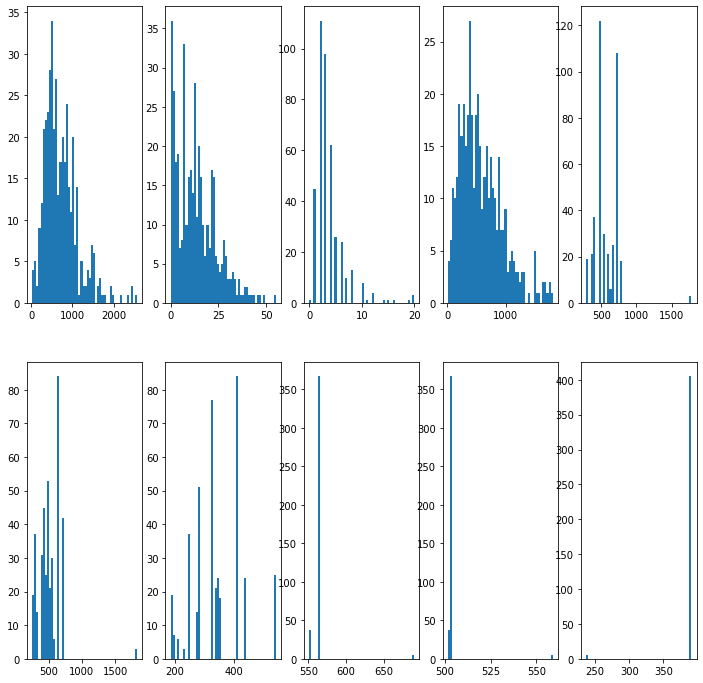

In [127]:
fig, axes = plt.subplots(2,5, figsize= (12,12))
i = 0
for f in scailing_features:
    c = i % 5
    r = i // 5
    
    axes[r,c].hist(x = f, bins =50, data = X_train)
    i += 1
plt.show()


# 지역은 이상치가 확인 => Robust Scailing
# 도보 -> std 제거
# 나머지는 Standard

In [128]:
# 도보 10분거리 std는 그림상 의미가 없기에 Drop
X_train = X_train.iloc[:,:-1]
X_test = X_test.iloc[:,:-1]

# 지역은  Scailing

scaler = RobustScaler()
loc_f = [    '지역_mean', 
             '지역_median',
             '지역_std', ]
X_train.loc[:, loc_f] = scaler.fit_transform(X_train[loc_f])
X_test.loc[:, loc_f] = scaler.transform(X_test[loc_f])

# 나머지 Scailing
scailing_features = ['총세대수',
                     '공가수',
                     '도보 10분거리 내 버스정류장 수',
                     '단지내주차면수',
                     '도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean',
                       '도보 10분거리 내 지하철역 수(환승노선 수 반영)_median',
                    ]

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

In [129]:
# reg = setup(X_train, 
#             preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
#             train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
#             target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
#             silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
#             use_gpu = False, # GPU가 있으면 사용하세요 (Cat BOost 속도 향상)
#             numeric_features=list(X_train.drop(columns = ['등록차량수']).columns), # 모든 변수가 숫자로써의 의미가 있다.
#             session_id = 2021,
#             fold_shuffle = True
#             )

In [130]:
X = X_train.drop(columns = ['등록차량수'])
y = X_train['등록차량수']

In [131]:
X.지역_median

C2515    0.000000
C1407   -0.146138
C1945    0.732777
C1470   -0.267223
C1898   -0.267223
           ...   
C2586   -0.628392
C2035   -0.726514
C2020   -0.162839
C2437    0.252610
C2532   -0.726514
Name: 지역_median, Length: 410, dtype: float64

In [132]:
# X = X.drop(['지역_median','지역_std'],axis=1)

In [133]:
X

,총세대수,공가수,도보 10분거리 내 버스정류장 수,단지내주차면수,임대건물구분_상가,공급유형_공공임대(50년),공급유형_공공임대(5년/10년/분납/분양),공급유형_국민임대/장기전세,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,지역_mean,지역_median,지역_std,도보 10분거리 내 지하철역 수(환승노선 수 반영)_mean,도보 10분거리 내 지하철역 수(환승노선 수 반영)_median
C2515,-0.438015,0.350709,-0.249358,0.115423,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.326922,0.000000,-0.001797,-0.017516,-0.088051
C1407,1.209451,-0.037390,-0.954438,1.952437,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.376414,-0.146138,1.691852,-0.969122,-0.330884
C1945,0.077586,-0.716563,-0.249358,0.421129,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.673078,0.732777,0.679994,-0.969122,-0.330884
C1470,-0.067274,0.059635,-0.601898,0.173785,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.312414,-0.267223,-0.320006,-0.017516,-0.088051
C1898,-0.386455,-0.425489,0.808263,-0.181946,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.312414,-0.267223,-0.320006,-0.017516,-0.088051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2586,-1.555149,-0.619538,-0.249358,-1.435340,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.721329,-0.628392,-0.357767,-0.017516,-0.088051
C2035,-0.568143,1.029882,-0.954438,-0.170829,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.666952,-0.726514,-0.569915,-0.017516,-0.088051
C2020,-1.677911,-0.619538,-0.601898,-1.549285,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.261181,-0.162839,0.000000,-0.969122,-0.330884
C2437,-1.555149,-0.134415,-0.954438,-1.535389,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.252610,-0.286986,-0.017516,-0.088051


In [134]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 1,
        "learning_rate": 0.01,
        "n_estimators": 100000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 150),
        "max_bin": trial.suggest_int("max_bin", 200, 600),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [135]:
sampler = TPESampler(seed=1)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)


[I 2021-07-26 00:48:32,663] A new study created in memory with name: cat_opt
[I 2021-07-26 00:48:33,476] Trial 0 finished with value: 109.92634947875614 and parameters: {'max_depth': 7, 'colsample_bylevel': 0.9440648986884317, 'subsample': 0.3000800623721414, 'min_child_samples': 49, 'max_bin': 258}. Best is trial 0 with value: 109.92634947875614.
[I 2021-07-26 00:48:33,694] Trial 1 finished with value: 109.27964613716138 and parameters: {'max_depth': 2, 'colsample_bylevel': 0.8372520422755342, 'subsample': 0.5418925089301334, 'min_child_samples': 62, 'max_bin': 416}. Best is trial 1 with value: 109.27964613716138.
[I 2021-07-26 00:48:35,066] Trial 2 finished with value: 153.02849307722008 and parameters: {'max_depth': 7, 'colsample_bylevel': 0.9370439000793519, 'subsample': 0.4431165748120622, 'min_child_samples': 133, 'max_bin': 210}. Best is trial 1 with value: 109.27964613716138.
[I 2021-07-26 00:48:44,994] Trial 3 finished with value: 127.16582672332301 and parameters: {'max_depth

Best Score: 106.90884384242564
Best trial: {'max_depth': 6, 'colsample_bylevel': 0.9373001855363168, 'subsample': 0.8842379703281611, 'min_child_samples': 7, 'max_bin': 500}


In [136]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

In [137]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(4)

preds = []
for tr_id, val_id in skf.split(X, y_cat) : 
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    
    pred = cat.predict(X_test)
    preds.append(pred)
cat_pred = np.mean(preds, axis = 0)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=4.



In [138]:
cat_pred

array([ 697.24039063, 1163.79787082,  564.12954062,  507.38072873,
       1095.4540313 , 1805.69204519,  831.00802353,  385.48844101,
        291.83352015,  321.29859611,  456.18841159,  369.6025159 ,
        327.57988886,  261.56256253,  342.39218542,  261.59994548,
        474.60009775,  340.9133056 ,  169.27712443,  716.44555111,
        283.1421723 ,  393.03513184,  439.87483543,  477.19476423,
        356.21224743,  169.32947961,  171.97897901,  490.91929696,
        407.7958033 ,  441.50807566,  826.28759523,  150.2178242 ,
        508.03401422,  255.36394218,  125.94520662,  327.60548946,
        460.02726988,  591.53757788,  834.92303411,  317.33382842,
        428.31914613,  427.29144172,  450.99845872,  548.67626529,
        814.18141071, 1358.1219744 ,  467.02596522,  652.54903144,
        408.99527399,  365.73150782,  792.77349605,  296.73783132,
       1060.93696755,  578.79353281,  512.65096737,  241.64959649,
        557.60263   ,  268.36841267,  440.39163666,  161.42053

In [139]:
cat_pred

array([ 697.24039063, 1163.79787082,  564.12954062,  507.38072873,
       1095.4540313 , 1805.69204519,  831.00802353,  385.48844101,
        291.83352015,  321.29859611,  456.18841159,  369.6025159 ,
        327.57988886,  261.56256253,  342.39218542,  261.59994548,
        474.60009775,  340.9133056 ,  169.27712443,  716.44555111,
        283.1421723 ,  393.03513184,  439.87483543,  477.19476423,
        356.21224743,  169.32947961,  171.97897901,  490.91929696,
        407.7958033 ,  441.50807566,  826.28759523,  150.2178242 ,
        508.03401422,  255.36394218,  125.94520662,  327.60548946,
        460.02726988,  591.53757788,  834.92303411,  317.33382842,
        428.31914613,  427.29144172,  450.99845872,  548.67626529,
        814.18141071, 1358.1219744 ,  467.02596522,  652.54903144,
        408.99527399,  365.73150782,  792.77349605,  296.73783132,
       1060.93696755,  578.79353281,  512.65096737,  241.64959649,
        557.60263   ,  268.36841267,  440.39163666,  161.42053

In [140]:

submission['num'] = cat_pred

submission.to_csv('catB.csv', index=False)

In [ ]:
    cat_pred = cat.predict(X)
    log_score = mean_absolute_error(y_val, cat_pred)